# DN-DETR for SAR Ship Detection Dataset with K-Fold Cross Validation

This notebook implements the DN-DETR model on SSD dataset, enabling the detection of aircraft of any scale on this dataset. With this notebook, you'll be able to train and evaluate this model on the aforementioned dataset.
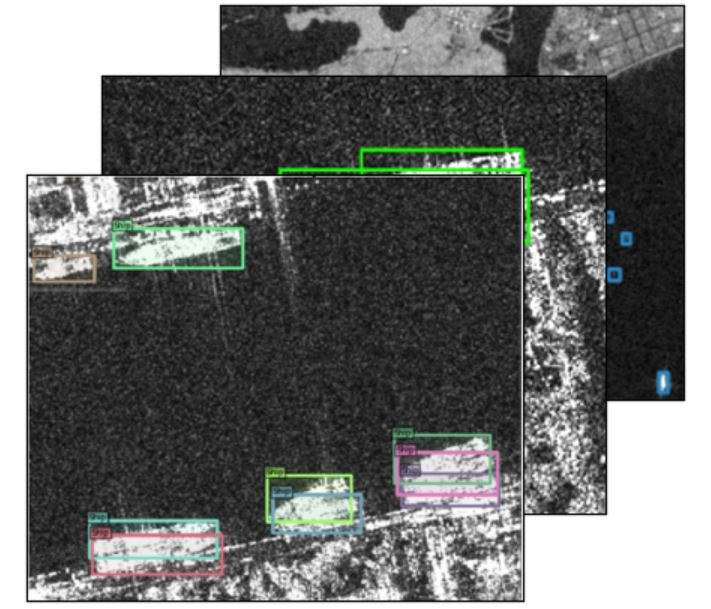

Mounting google drive:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Preparing the working environment:

In [ ]:
# Copy DINO files and model weights
!cp -r /content/drive/MyDrive/DN-DETR-main/* /content
!cp -r /content/drive/MyDrive/checkpoint_DN_DEFORMABLE_DETR.pth /content/checkpoint_DN_DEFORMABLE_DETR.pth

Installation of dependencies:

In [ ]:
!pip install -r requirements.txt

!pip install yapf==0.33.0
!pip install pycocotools==2.0.8

# Installer entmax et geomloss (utile si vous utilisez des extensions spécifiques)
!pip install entmax
!pip install --no-cache-dir geomloss

!wget https://developer.download.nvidia.com/compute/cuda/11.8.0/local_installers/cuda_11.8.0_520.61.05_linux.run
!chmod +x cuda_11.8.0_520.61.05_linux.run
!./cuda_11.8.0_520.61.05_linux.run --silent --toolkit

import os
os.environ["CUDA_HOME"] = "/usr/local/cuda-11.8"
os.environ["PATH"] += ":/usr/local/cuda-11.8/bin"
os.environ["LD_LIBRARY_PATH"] += ":/usr/local/cuda-11.8/lib64"

!pip install --no-cache-dir "numpy<2"

!pip install torch==2.0.0 torchvision==0.15.1 torchaudio==2.0.0 --index-url https://download.pytorch.org/whl/cu118

!python /content/models/dn_dab_deformable_detr/ops/setup.py build install

Restart The runtime here

Methods and functions definition

In [ ]:
import shutil
import json
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split, KFold
import torch
import time
from collections import defaultdict


# Access paths
DATASET_PATH = '/content/drive/MyDrive/SSDD------Dataset'
ANNOTATIONS_PATH = '/content/drive/MyDrive/annotations_coco_ships.csv'
TRAIN_JSON_PATH = '/content/Dataset/annotations/instances_train2017.json'
VAL_JSON_PATH = '/content/Dataset/annotations/instances_val2017.json'
TEST_JSON_PATH = '/content/Dataset/annotations/image_info_test-dev2017.json'
TRAIN_DIR = '/content/Dataset/train2017/'
VAL_DIR = '/content/Dataset/val2017/'
TEST_DIR = '/content/Dataset/test2017/'

# Load annotations
annotations_df = pd.read_csv(ANNOTATIONS_PATH)

image_files=annotations_df['id'].drop_duplicates().tolist()

# k-fold configuration
kf = KFold(n_splits=10, shuffle=True, random_state=42)
fold_metrics = []

# Function for creating COCO annotations
def create_coco_json(images_list, annotations_df, output_path):
    coco_json = {
        "info": {"description": "SSDD Dataset"},
        "images": [],
        "annotations": [],
        "categories": [{"supercategory": "Ship", "id": 1, "name": "Ship"}]
    }
    annotation_id = 0

    for image_id, image_name in enumerate(images_list):
        coco_json["images"].append({"file_name": image_name, "id": image_id})
        image_annotations = annotations_df[annotations_df['id'] == image_name]
        for _, row in image_annotations.iterrows():
            x, y, w, h = eval(row['bbox'])
            coco_json["annotations"].append({
                "iscrowd": 0,
                "image_id": image_id,
                "bbox": [x, y, w, h],
                "area": w * h,
                "category_id": 1,
                "id": annotation_id
            })
            annotation_id += 1

    with open(output_path, 'w') as f:
        json.dump(coco_json, f)
    print(f"Annotations saved in {output_path}")


def convert_cxcywh_to_xyxy(box, width, height):
    """
    Convertit une boîte du format [cx, cy, w, h] (normalisé) au format [x_min, y_min, x_max, y_max] (pixels absolus).

    Args:
        box (list): Boîte au format [cx, cy, w, h].
        width (int): Largeur de l'image.
        height (int): Hauteur de l'image.

    Returns:
        list: Boîte au format [x_min, y_min, x_max, y_max].
    """
    cx, cy, w, h = box
    x_min = (cx - w / 2) * width
    y_min = (cy - h / 2) * height
    x_max = (cx + w / 2) * width
    y_max = (cy + h / 2) * height
    return [x_min, y_min, x_max, y_max]

def calculate_ap(pred_boxes, pred_scores, true_boxes, iou_threshold=0.5):
    """
    Calcule l'Average Precision (AP) pour une image donnée, en prenant en compte le format Pascal VOC.

    Args:
        pred_boxes (list or numpy array): Boîtes prédites au format [xmin, ymin, xmax, ymax].
        pred_scores (list or numpy array): Scores associés aux boîtes prédites.
        true_boxes (list or numpy array): Boîtes vérité terrain au format [xmin, ymin, xmax, ymax].
        iou_threshold (float): Seuil IoU pour considérer une correspondance comme correcte.

    Returns:
        float: Average Precision (AP).
    """
    if len(pred_boxes) == 0 or len(true_boxes) == 0:
        return 0.0  # Si aucune prédiction ou vérité terrain, AP est 0

    # Sort predictions by descending score
    sorted_indices = np.argsort(pred_scores)[::-1]
    pred_boxes = [pred_boxes[i] for i in sorted_indices]
    pred_scores = [pred_scores[i] for i in sorted_indices]

    # Variable initialization
    tp = np.zeros(len(pred_boxes))
    fp = np.zeros(len(pred_boxes))
    matched_true_boxes = set()


    for i, pred_box in enumerate(pred_boxes):
        iou_scores = [iou(pred_box, gt_box) for gt_box in true_boxes]

        if max(iou_scores) > iou_threshold:
            max_index = iou_scores.index(max(iou_scores))
            if max_index not in matched_true_boxes:
                tp[i] = 1
                matched_true_boxes.add(max_index)
            else:
                fp[i] = 1
        else:
            fp[i] = 1


    tp_cumsum = np.cumsum(tp)
    fp_cumsum = np.cumsum(fp)


    precisions = tp_cumsum / (tp_cumsum + fp_cumsum + 1e-6)
    recalls = tp_cumsum / (len(true_boxes) + 1e-6)


    precisions = np.concatenate([[0.0], precisions, [0.0]])
    recalls = np.concatenate([[0.0], recalls, [1.0]])
    precisions = np.maximum.accumulate(precisions[::-1])[::-1]

    ap = np.trapz(precisions, recalls)

    return ap


def convert_to_xyxy(box):
    """
    Convertit une boîte du format [cx, cy, w, h] (centre, largeur, hauteur)
    au format [x_min, y_min, x_max, y_max].

    Args:
        box (list or array): Boîte au format [cx, cy, w, h].

    Returns:
        list: Boîte convertie au format [x_min, y_min, x_max, y_max].
    """
    cx, cy, w, h = box
    x_min = cx - w / 2
    y_min = cy - h / 2
    x_max = cx + w / 2
    y_max = cy + h / 2
    return [x_min, y_min, x_max, y_max]

def calculate_map(pred_boxes, pred_scores, true_boxes, iou_thresholds=np.linspace(0.5, 0.95, 10)):
    """
    Calcule la métrique mAP@[IoU=0.5:0.95] pour une image donnée.

    Args:
        pred_boxes (list): Liste des boîtes prédites au format [xmin, ymin, xmax, ymax].
        pred_scores (list): Liste des scores associés aux boîtes prédites.
        true_boxes (list): Liste des boîtes vérité terrain au format [xmin, ymin, xmax, ymax].
        iou_thresholds (numpy array): Seuils IoU à utiliser pour le calcul de l'AP.

    Returns:
        float: Mean Average Precision (mAP).
    """
    aps = []

    for iou_threshold in iou_thresholds:
        ap = calculate_ap(pred_boxes, pred_scores, true_boxes, iou_threshold)
        aps.append(ap)
    return np.mean(aps)

def calculate_map50(pred_boxes, pred_scores, true_boxes):
    """
    Calcule mAP50 (IoU=0.5).
    """
    return calculate_ap(pred_boxes, pred_scores, true_boxes, iou_threshold=0.5)

def calculate_map75(pred_boxes, pred_scores, true_boxes):
    """
    Calcule mAP75 (IoU=0.75).
    """
    return calculate_ap(pred_boxes, pred_scores, true_boxes, iou_threshold=0.75)





def iou(box1, box2):
    x1_min, y1_min, x1_max, y1_max = box1
    x2_min, y2_min, x2_max, y2_max = box2

    xi1 = max(x1_min, x2_min)
    yi1 = max(y1_min, y2_min)
    xi2 = min(x1_max, x2_max)
    yi2 = min(y1_max, y2_max)

    intersection_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)
    box1_area = (x1_max - x1_min) * (y1_max - y1_min)
    box2_area = (x2_max - x2_min) * (y2_max - y2_min)

    return intersection_area / float(box1_area + box2_area - intersection_area + 1e-6)

### Cross-Validation with K-Fold and Evaluation on COCO Dataset

This cell performs the following operations:

1. **Import Necessary Modules**:
   - Modules for building the model (`build_model_main`) and loading datasets (`build_dataset`) are imported.
   - Utility libraries such as `pycocotools` for handling COCO datasets and evaluation.

2. **COCO Visualizer Initialization**:
   - A visualizer is initialized for displaying ground-truth annotations and predictions.

3. **K-Fold Cross-Validation Setup**:
   - For each fold, the dataset is divided into training, validation, and test sets.
   - Images are distributed into respective folders, and COCO JSON annotations are generated for each set.

4. **Model Training**:
   - The `main_DINO.py` script is executed for training using pre-defined hyperparameters for each fold.

5. **Evaluation**:
   - The trained model is loaded for inference on the test set.
   - Predictions are filtered based on confidence thresholds and compared against ground-truth annotations to calculate metrics such as precision, recall, F1-score, and mean Average Precision (mAP).

6. **Visualization**:
   - Both ground-truth and predicted bounding boxes are visualized and saved for analysis.

7. **Metric Computation**:
   - Metrics such as Precision, Recall, F1-Score, mAP@50, and mAP@75 are calculated for each fold.

This process provides a robust evaluation of the model's performance using cross-validation, ensuring consistency and reliability in the results.

In [ ]:
import torch
import shutil
import os
import json
import numpy as np
import time
import gc
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
import pandas as pd
from pycocotools.coco import COCO
from datasets import build_dataset
from main import build_model_main, get_args_parser
from util.visualizer import COCOVisualizer
from util import box_ops
from util.misc import nested_tensor_from_tensor_list

vslzr = COCOVisualizer()
all_precision, all_recall, all_f1_score = [], [], []
all_map, all_map50, all_map75 = [], [], []

annotations_df = pd.read_csv(ANNOTATIONS_PATH)
image_files = annotations_df['id'].drop_duplicates().tolist()
kf = KFold(n_splits=10, shuffle=True, random_state=42)

THRESHOLD = 0.4

def convert_xyxy_to_cxcywh(box, width, height):
    x_min, y_min, x_max, y_max = box
    cx = ((x_min + x_max) / 2) / width
    cy = ((y_min + y_max) / 2) / height
    w = (x_max - x_min) / width
    h = (y_max - y_min) / height
    return [cx, cy, w, h]

for fold_idx, (train_idx, temp_idx) in enumerate(kf.split(image_files)):
    print(f"\n=== Processing Fold {fold_idx + 1} ===")

    for folder in [TRAIN_DIR, VAL_DIR, TEST_DIR, '/content/Dataset/annotations']:
        if os.path.exists(folder):
            shutil.rmtree(folder)
        os.makedirs(folder, exist_ok=True)

    train_images = [image_files[i] for i in train_idx]
    temp_images = [image_files[i] for i in temp_idx]
    val_images, test_images = train_test_split(temp_images, test_size=0.5, random_state=42)

    for image_name in train_images:
        shutil.copy(os.path.join(DATASET_PATH, image_name), os.path.join(TRAIN_DIR, image_name))
    for image_name in val_images:
        shutil.copy(os.path.join(DATASET_PATH, image_name), os.path.join(VAL_DIR, image_name))
    for image_name in test_images:
        shutil.copy(os.path.join(DATASET_PATH, image_name), os.path.join(TEST_DIR, image_name))

    create_coco_json_two_classes(train_images, annotations_df, TRAIN_JSON_PATH)
    create_coco_json_two_classes(val_images, annotations_df, VAL_JSON_PATH)
    create_coco_json_two_classes(test_images, annotations_df, TEST_JSON_PATH)

    output_dir = f"/content/logs/DN-DETR/fine_tune_R50-MS4_fold{fold_idx + 1}"
    os.makedirs(output_dir, exist_ok=True)

    print(f"Training Fold {fold_idx + 1} ...")
    start_time = time.time()

    !python main.py \
        --modelname dn_dab_deformable_detr \
        --coco_path /content/Dataset \
        --output_dir {output_dir} \
        --epochs 12 \
        --batch_size 1 \
        --device cuda \
        --pretrain_model_path /content/checkpoint_DN_DEFORMABLE_DETR.pth \
        --finetune_ignore label_enc.weight class_embed \
        --find_unused_params \
        --use_dn

    elapsed_time = time.time() - start_time
    print(f"Training Time Fold {fold_idx + 1}: {elapsed_time:.2f} seconds")

    checkpoint_path = os.path.join(output_dir, 'checkpoint.pth')
    shutil.copy2(checkpoint_path, "/content/drive/MyDrive/DN-DETR_SSDD.pth")
    checkpoint = torch.load(checkpoint_path, map_location='cuda' if torch.cuda.is_available() else 'cpu')

    parser = get_args_parser()
    args = parser.parse_args(args=[
        '--modelname', 'dn_dab_deformable_detr',
        '--coco_path', '/content/Dataset',
        '--device', 'cuda'
    ])
    model, criterion, postprocessors = build_model_main(args)
    model.load_state_dict(checkpoint['model'], strict=False)
    model.to(args.device)
    model.eval()

    dataset_test = build_dataset('test', args)
    coco = COCO(TEST_JSON_PATH)

    with open('util/coco_id2name_Pleiades.json') as f:
        id2name = {int(k): v for k, v in json.load(f).items()}

    fold_tp, fold_fp, fold_fn = 0, 0, 0
    map_per_image, map50_per_image, map75_per_image = [], [], []

    for idx in range(len(dataset_test)):
        image, targets = dataset_test[idx]
        image = image.to(args.device)
        image_id = targets['image_id'].item()
        height, width = image.shape[1], image.shape[2]

        gt_labels = targets['labels'].cpu().numpy()
        gt_boxes = targets['boxes'].cpu().numpy()
        gt_box_label = [id2name[int(lbl)] for lbl in gt_labels]
        gt_dict = {
            'boxes': targets['boxes'],
            'image_id': targets['image_id'],
            'size': targets['size'],
            'box_label': gt_box_label,
        }

        with torch.no_grad():
            outputs, _ = model(image[None], 0)
            outputs = postprocessors['bbox'](outputs, torch.tensor([[1.0, 1.0]]).to(args.device))[0]

        scores = outputs['scores']
        labels = outputs['labels']
        boxes_xyxy = outputs['boxes']  # Normalized [0, 1]
        select_mask = scores > THRESHOLD

        boxes_xyxy = boxes_xyxy[select_mask]
        labels = labels[select_mask].cpu().numpy()
        scores_selected = scores[select_mask].cpu().numpy()

        boxes_xyxy_pixel = boxes_xyxy * torch.tensor([width, height, width, height]).to(boxes_xyxy.device)

        print(f"Image {idx} | Predictions above threshold {THRESHOLD}: {len(scores_selected)}")
        print("Predicted boxes in pixel coordinates:")
        for b in boxes_xyxy_pixel:
            print(b.cpu().numpy())

        boxes_coco = [convert_xyxy_to_cxcywh(box.cpu().numpy(), width, height) for box in boxes_xyxy_pixel]
        pred_box_label = [id2name[int(lbl)] for lbl in labels]
        pred_dict = {
            'boxes': torch.tensor(boxes_coco),
            'size': targets['size'],
            'box_label': pred_box_label,
            'image_id': targets['image_id']
        }

        vslzr.visualize(image.cpu(), gt_dict, savedir=f'/content/test_results/ground_truth/gt_fold{fold_idx + 1}_img{idx}.png')
        vslzr.visualize(image.cpu(), pred_dict, savedir=f'/content/test_results/predictions/pred_fold{fold_idx + 1}_img{idx}.png')
        plt.close('all')

        boxes_xyxy_np = boxes_xyxy_pixel.cpu().numpy()
        gt_boxes_xyxy = [box_ops.box_cxcywh_to_xyxy(torch.tensor(box)).numpy() for box in gt_boxes]
        gt_boxes_xyxy = [box * np.array([width, height, width, height]) for box in gt_boxes_xyxy]

        assigned_gt = set()
        for pred_box, pred_label in zip(boxes_xyxy_np, labels):
            best_iou, best_gt_idx = 0, -1
            for gt_idx, (gt_box, gt_label) in enumerate(zip(gt_boxes_xyxy, gt_labels)):
                if gt_label == pred_label:
                    iou_val = iou(pred_box, gt_box)
                    if iou_val > best_iou:
                        best_iou = iou_val
                        best_gt_idx = gt_idx
            if best_iou > 0.5 and best_gt_idx not in assigned_gt:
                fold_tp += 1
                assigned_gt.add(best_gt_idx)
            else:
                fold_fp += 1
        fold_fn += len(gt_boxes_xyxy) - len(assigned_gt)

        map_per_image.append(calculate_map(boxes_xyxy_np, scores_selected, gt_boxes_xyxy))
        map50_per_image.append(calculate_map50(boxes_xyxy_np, scores_selected, gt_boxes_xyxy))
        map75_per_image.append(calculate_map75(boxes_xyxy_np, scores_selected, gt_boxes_xyxy))

        del image, targets, outputs, gt_boxes, boxes_xyxy_np, pred_dict, gt_dict
        torch.cuda.empty_cache()
        gc.collect()

    fold_precision = fold_tp / (fold_tp + fold_fp) if (fold_tp + fold_fp) > 0 else 0
    fold_recall = fold_tp / (fold_tp + fold_fn) if (fold_tp + fold_fn) > 0 else 0
    fold_f1_score = 2 * (fold_precision * fold_recall) / (fold_precision + fold_recall + 1e-7)

    map_value = np.mean(map_per_image)
    map50_value = np.mean(map50_per_image)
    map75_value = np.mean(map75_per_image)

    print(f"\n=== Metrics Fold {fold_idx + 1} ===")
    print(f"Precision: {fold_precision:.4f}, Recall: {fold_recall:.4f}, F1-Score: {fold_f1_score:.4f}")
    print(f"mAP: {map_value:.4f}, mAP50: {map50_value:.4f}, mAP75: {map75_value:.4f}")

    all_precision.append(fold_precision)
    all_recall.append(fold_recall)
    all_f1_score.append(fold_f1_score)
    all_map.append(map_value)
    all_map50.append(map50_value)
    all_map75.append(map75_value)

    fold_tp, fold_fp, fold_fn = 0, 0, 0

Calculating and displaying mean metrics for all folds

In [ ]:
mean_precision = np.mean(all_precision)
mean_recall = np.mean(all_recall)
mean_f1_score = np.mean(all_f1_score)


print(f"\n=== Mean metrics over all folds ===")
print(f"Mean Precision : {mean_precision:.4f}")
print(f"Mean Recall: {mean_recall:.4f}")
print(f"Mean F1-Score: {mean_f1_score:.4f}")



mean_map = np.mean(all_map)
mean_map50 = np.mean(all_map50)
mean_map75 = np.mean(all_map75)


print(f"Mean mAP: {mean_map:.4f}")
print(f"Mean mAP50: {mean_map50:.4f}")
print(f"Mean mAP75: {mean_map75:.4f}")